## Date: 19 MARCH 2021 at 1:10 PM
## 10 sec segmented EDA data

In [20]:
#============================
# Import important libraries
#============================
import pandas as pd 
import numpy as np
import scipy
import pywt
from creme import metrics
import time
import datetime
import math

from statistics import mode
from scipy import stats
from sklearn import preprocessing

from collections import defaultdict, Counter
from scipy.special import expit

from ANN_cls import *
from LR_cls import *

from window_slider import Slider



from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [21]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)> 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):    
    list_values = list_values[0,:]
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [22]:
#======================================================
# EDA Feature Extraction (Wavelet Features)
#======================================================
def extract_eda_features(raw_eda):
    features =[]
    EDA = raw_eda
    list_coeff = pywt.wavedec(EDA, 'db4', level=3)
    
#     print(list_coeff)
    for coeff in list_coeff:
        features += get_features(coeff)
    return features


In [23]:
##===================================================
# EDA data read from files
##===================================================
def eda_data(p,v):
    file_eda = '/home/gp/Desktop/MER_arin/data/eda_data/'+str(p)+'_GSR_data_from_DEAP.csv'
    print(file_eda)
    df = pd.read_csv(file_eda,sep=',', header = None)
    eda_sig = df.loc[df.iloc[:,1] == v]
    return eda_sig

In [24]:
#=======================================
# MAIN PROGRAM STARTS HERE
#=======================================
segment_in_sec = 10 #in sec
bucket_size = int((8064/60)*segment_in_sec)  #8064 is for 60 sec record
print(bucket_size)
overlap_count = 0

eta = 0.05

l_max =0.9999
lr_min = 0.0001
eta_init = 1
b =1 

n_epoch =1
epochs =  1 #epoch is 1 because the model will be trained only once
optimizer= 'sgd' #optimizer
classifier = 'mlp-'+str(optimizer)
c = 0
run = 1

participant = 32
videos = 40

global eeg_emotion, eda_emotion, resp_emotion, mer_emotion, all_eta
eeg_emotion = []
eda_emotion = []
resp_emotion = []
mer_emotion = []

all_eta =[]
init_m = 0

#================================================
# Performance matric declaration here
#================================================

eda_acc_val = metrics.Accuracy() #Accuracy
eda_f1m_val = metrics.F1() #F1 measure  
eda_acc_aro = metrics.Accuracy() #Accuracy
eda_f1m_aro = metrics.F1() #F1 measure
    
itr = 0 #controls the learning rate


for ii in range(0,participant):


        # if(ii >2):
        # 	break

        p =ii+1
        for jj in range(0,videos):
            v = jj+1
            p_v = 'Person:'+ ' ' +str(p)+ ' ' +'Video:'+str(v)
            
        
            ##===================================================
            # EDA data read from files
            ##===================================================
            eda_sig = eda_data(p,v)
            #=================================================
            #emotion labels (valence, arousal) mapping 0-1
            #=================================================
            val = eda_sig.iloc[0,8067]
            aro = eda_sig.iloc[0,8068]
            
#             print('val:{}, arousal:{}'.format(val,aro))

            #valence emotion maping 0-> low valence and 1-> high valence

            if (val >5):
                vl = 1 #high valence
            else:
                vl = 0 #low valence

            #arousal emotion maping 0-> low arousal and 1-> high high arousal
            if (aro >5):
                al = 1 #high arousal
            else:
                al = 0 #low arousal
                
            y_act_val = vl
            y_act_aro = al   
            
            #=========================================
            # Sliding window starts here 
            #=========================================
            slider = Slider(bucket_size,overlap_count)
            eda_sig = np.array(eda_sig.iloc[:,range(3,8067)]) #keeping only eeg signals
            
            print(eda_sig.shape)
            slider.fit(eda_sig)   

            while True:
                window_data = slider.slide()
                #=================================================
                # Feature extraction from EDA
                #=================================================
                eda_features = extract_eda_features(np.array(window_data))
                eda = np.array([eda_features]) #EDA raw feature vector
                x_eda = preprocessing.normalize(eda) #EDA normalized features           
                
            
                #===================================================
                # Model initialization
                #===================================================
                if init_m == 0:
                    eda_size_hidden = math.ceil(x_eda.shape[1]*(2/3))

                    #========================
                    # For EDA data MLp model
                    #========================
                    eda_model_val = ANN()
                    eda_model_val.add(layers.layer(x_eda.shape[1], 'sigmoid'))
                    eda_model_val.add(layers.layer(eda_size_hidden, 'sigmoid'))
                    eda_model_val.add(layers.layer(1, 'sigmoid'))

                    eda_model_aro = ANN()
                    eda_model_aro.add(layers.layer(x_eda.shape[1], 'sigmoid'))
                    eda_model_aro.add(layers.layer(eda_size_hidden, 'sigmoid'))
                    eda_model_aro.add(layers.layer(1, 'sigmoid'))


                    init_m = init_m+1


                #===============================================================
                # Emotion Classification --> Valence and Arousal
                #===============================================================

                #===========================================
                # From EDA data 
                #===========================================

                #Valence classification EDA

                #Test the model first 
                y_pred_val_eda = eda_model_val.predict_once(x_eda,c)

                #Train the model once
                eda_model_val.fit_once(x_eda,y_act_val, eta,c)

                eda_acc_val = eda_acc_val.update(y_act_val, y_pred_val_eda)  # update the accuracy metric

                eda_f1m_val = eda_f1m_val.update(y_act_val, y_pred_val_eda) #update f1 measure metric

                #Arousal classification EDA
                #Test the model first 
                y_pred_aro_eda = eda_model_aro.predict_once(x_eda,c)

                #Train the model once
                eda_model_aro.fit_once(x_eda,y_act_aro, eta,c)

                eda_acc_aro = eda_acc_aro.update(y_act_aro, y_pred_aro_eda)  # update the accuracy metric

                eda_f1m_aro = eda_f1m_aro.update(y_act_aro, y_pred_aro_eda) #update f1 measure metric
                
                if slider.reached_end_of_list(): break


    #             print(c)
                c = c+1

            
            eda_emotion.append(np.array([p,v,eda_acc_val.get(), eda_f1m_val.get(), eda_acc_aro.get(), eda_f1m_aro.get(), y_act_val, y_pred_val_eda, y_act_aro, y_pred_aro_eda]))
            print('===============================================================')
            print(p_v)
            print('Actual emotion [valence: {}, arousal: {}]'.format(y_act_val, y_act_aro))
            print('Predicted emotion [valence: {}, arousal: {}]'.format(y_pred_val_eda, y_pred_aro_eda))

            print('..................................................')
            print('EDA')

            print("Valence Accuracy:{}".format(round(eda_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(eda_f1m_val.get(),4)))
            print("Arousal Accuracy:{}".format(round(eda_acc_val.get(),4)))
            print("Arousal F1 score:{}".format(round(eda_f1m_val.get(),4)))
            
                
                
            


1344
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.6667
Valence F1 score:0.8
Arousal Accuracy:0.6667
Arousal F1 score:0.8
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8333
Valence F1 score:0.9091
Arousal Accuracy:0.8333
Arousal F1 score:0.9091
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8889
Valence F1 score:0.9412
Arousal Accuracy:0.8889
Arousal F1 score:0.9412
/h

(1, 8064)
Person: 1 Video:22
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9091
Valence F1 score:0.9211
Arousal Accuracy:0.9091
Arousal F1 score:0.9211
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:23
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.913
Valence F1 score:0.9268
Arousal Accuracy:0.913
Arousal F1 score:0.9268
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:24
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9167
Valence F1 score:0.9318
Arousal Accuracy:0.9167
Arousal F1 score:0.9318
/home/gp/Desktop/MER_arin/data/eda_data/1_GSR_data_from_DEAP.csv


(1, 8064)
Person: 2 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9302
Valence F1 score:0.9302
Arousal Accuracy:0.9302
Arousal F1 score:0.9302
/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:4
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9318
Valence F1 score:0.9333
Arousal Accuracy:0.9318
Arousal F1 score:0.9333
/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:5
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9333
Valence F1 score:0.9362
Arousal Accuracy:0.9333
Arousal F1 score:0.9362
/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
(

(1, 8064)
Person: 2 Video:24
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9141
Valence F1 score:0.9248
Arousal Accuracy:0.9141
Arousal F1 score:0.9248
/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:25
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9154
Valence F1 score:0.9268
Arousal Accuracy:0.9154
Arousal F1 score:0.9268
/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:26
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9167
Valence F1 score:0.9287
Arousal Accuracy:0.9167
Arousal F1 score:0.9287
/home/gp/Desktop/MER_arin/data/eda_data/2_GSR_data_from_DEAP.cs

(1, 8064)
Person: 3 Video:5
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9157
Valence F1 score:0.9193
Arousal Accuracy:0.9157
Arousal F1 score:0.9193
/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:6
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9167
Valence F1 score:0.9211
Arousal Accuracy:0.9167
Arousal F1 score:0.9211
/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:7
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9176
Valence F1 score:0.9228
Arousal Accuracy:0.9176
Arousal F1 score:0.9228
/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
(

(1, 8064)
Person: 3 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9198
Valence F1 score:0.9264
Arousal Accuracy:0.9198
Arousal F1 score:0.9264
/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9159
Valence F1 score:0.9231
Arousal Accuracy:0.9159
Arousal F1 score:0.9231
/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:28
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9167
Valence F1 score:0.9244
Arousal Accuracy:0.9167
Arousal F1 score:0.9244
/home/gp/Desktop/MER_arin/data/eda_data/3_GSR_data_from_DEAP.cs

(1, 8064)
Person: 4 Video:7
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9016
Valence F1 score:0.9061
Arousal Accuracy:0.9016
Arousal F1 score:0.9061
/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.901
Valence F1 score:0.9062
Arousal Accuracy:0.901
Arousal F1 score:0.9062
/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:9
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9018
Valence F1 score:0.9075
Arousal Accuracy:0.9018
Arousal F1 score:0.9075
/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
(1,

(1, 8064)
Person: 4 Video:28
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8919
Valence F1 score:0.8987
Arousal Accuracy:0.8919
Arousal F1 score:0.8987
/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:29
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8926
Valence F1 score:0.8987
Arousal Accuracy:0.8926
Arousal F1 score:0.8987
/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:30
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8933
Valence F1 score:0.8987
Arousal Accuracy:0.8933
Arousal F1 score:0.8987
/home/gp/Desktop/MER_arin/data/eda_data/4_GSR_data_from_DEAP.cs

(1, 8064)
Person: 5 Video:9
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8974
Valence F1 score:0.899
Arousal Accuracy:0.8974
Arousal F1 score:0.899
/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8961
Valence F1 score:0.8973
Arousal Accuracy:0.8961
Arousal F1 score:0.8973
/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8957
Valence F1 score:0.8974
Arousal Accuracy:0.8957
Arousal F1 score:0.8974
/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
(

(1, 8064)
Person: 5 Video:30
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8965
Valence F1 score:0.9008
Arousal Accuracy:0.8965
Arousal F1 score:0.9008
/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:31
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8953
Valence F1 score:0.9
Arousal Accuracy:0.8953
Arousal F1 score:0.9
/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:32
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.895
Valence F1 score:0.8993
Arousal Accuracy:0.895
Arousal F1 score:0.8993
/home/gp/Desktop/MER_arin/data/eda_data/5_GSR_data_from_DEAP.csv
(1, 80

(1, 8064)
Person: 6 Video:11
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8989
Valence F1 score:0.9057
Arousal Accuracy:0.8989
Arousal F1 score:0.9057
/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:12
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8986
Valence F1 score:0.9058
Arousal Accuracy:0.8986
Arousal F1 score:0.9058
/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:13
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8991
Valence F1 score:0.9066
Arousal Accuracy:0.8991
Arousal F1 score:0.9066
/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.cs

(1, 8064)
Person: 6 Video:32
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9016
Valence F1 score:0.9123
Arousal Accuracy:0.9016
Arousal F1 score:0.9123
/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:33
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.902
Valence F1 score:0.913
Arousal Accuracy:0.902
Arousal F1 score:0.913
/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:34
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.901
Valence F1 score:0.9119
Arousal Accuracy:0.901
Arousal F1 score:0.9119
/home/gp/Desktop/MER_arin/data/eda_data/6_GSR_data_from_DEAP.csv
(1, 

(1, 8064)
Person: 7 Video:13
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9045
Valence F1 score:0.9174
Arousal Accuracy:0.9045
Arousal F1 score:0.9174
/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:14
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9049
Valence F1 score:0.9179
Arousal Accuracy:0.9049
Arousal F1 score:0.9179
/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:15
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9052
Valence F1 score:0.9185
Arousal Accuracy:0.9052
Arousal F1 score:0.9185
/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.cs

(1, 8064)
Person: 7 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8996
Valence F1 score:0.9117
Arousal Accuracy:0.8996
Arousal F1 score:0.9117
/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:35
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8988
Valence F1 score:0.9111
Arousal Accuracy:0.8988
Arousal F1 score:0.9111
/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:36
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8986
Valence F1 score:0.9111
Arousal Accuracy:0.8986
Arousal F1 score:0.9111
/home/gp/Desktop/MER_arin/data/eda_data/7_GSR_data_from_DEAP.cs

(1, 8064)
Person: 8 Video:15
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8994
Valence F1 score:0.9152
Arousal Accuracy:0.8994
Arousal F1 score:0.9152
/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:16
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8986
Valence F1 score:0.9143
Arousal Accuracy:0.8986
Arousal F1 score:0.9143
/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8984
Valence F1 score:0.9143
Arousal Accuracy:0.8984
Arousal F1 score:0.9143
/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.cs

(1, 8064)
Person: 8 Video:36
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8966
Valence F1 score:0.9103
Arousal Accuracy:0.8966
Arousal F1 score:0.9103
/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:37
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8954
Valence F1 score:0.9093
Arousal Accuracy:0.8954
Arousal F1 score:0.9093
/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:38
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8941
Valence F1 score:0.9081
Arousal Accuracy:0.8941
Arousal F1 score:0.9081
/home/gp/Desktop/MER_arin/data/eda_data/8_GSR_data_from_DEAP.cs

(1, 8064)
Person: 9 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8917
Valence F1 score:0.908
Arousal Accuracy:0.8917
Arousal F1 score:0.908
/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:18
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.891
Valence F1 score:0.9073
Arousal Accuracy:0.891
Arousal F1 score:0.9073
/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:19
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8913
Valence F1 score:0.9073
Arousal Accuracy:0.8913
Arousal F1 score:0.9073
/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
(1

(1, 8064)
Person: 9 Video:38
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8883
Valence F1 score:0.9018
Arousal Accuracy:0.8883
Arousal F1 score:0.9018
/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:39
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8886
Valence F1 score:0.9018
Arousal Accuracy:0.8886
Arousal F1 score:0.9018
/home/gp/Desktop/MER_arin/data/eda_data/9_GSR_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:40
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.888
Valence F1 score:0.9014
Arousal Accuracy:0.888
Arousal F1 score:0.9014
/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv

(1, 8064)
Person: 10 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8879
Valence F1 score:0.9037
Arousal Accuracy:0.8879
Arousal F1 score:0.9037
/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
(1, 8064)
Person: 10 Video:20
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8882
Valence F1 score:0.9042
Arousal Accuracy:0.8882
Arousal F1 score:0.9042
/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_DEAP.csv
(1, 8064)
Person: 10 Video:21
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8867
Valence F1 score:0.9028
Arousal Accuracy:0.8867
Arousal F1 score:0.9028
/home/gp/Desktop/MER_arin/data/eda_data/10_GSR_data_from_D

(1, 8064)
Person: 10 Video:40
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8871
Valence F1 score:0.8996
Arousal Accuracy:0.8871
Arousal F1 score:0.8996
/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
(1, 8064)
Person: 11 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8874
Valence F1 score:0.9
Arousal Accuracy:0.8874
Arousal F1 score:0.9
/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
(1, 8064)
Person: 11 Video:2
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8876
Valence F1 score:0.9005
Arousal Accuracy:0.8876
Arousal F1 score:0.9005
/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv


(1, 8064)
Person: 11 Video:21
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.888
Valence F1 score:0.9036
Arousal Accuracy:0.888
Arousal F1 score:0.9036
/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
(1, 8064)
Person: 11 Video:22
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8878
Valence F1 score:0.9036
Arousal Accuracy:0.8878
Arousal F1 score:0.9036
/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEAP.csv
(1, 8064)
Person: 11 Video:23
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8869
Valence F1 score:0.9027
Arousal Accuracy:0.8869
Arousal F1 score:0.9027
/home/gp/Desktop/MER_arin/data/eda_data/11_GSR_data_from_DEA

(1, 8064)
Person: 12 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8873
Valence F1 score:0.901
Arousal Accuracy:0.8873
Arousal F1 score:0.901
/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8875
Valence F1 score:0.9014
Arousal Accuracy:0.8875
Arousal F1 score:0.9014
/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:4
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8878
Valence F1 score:0.9018
Arousal Accuracy:0.8878
Arousal F1 score:0.9018
/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.c

(1, 8064)
Person: 12 Video:23
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8852
Valence F1 score:0.9008
Arousal Accuracy:0.8852
Arousal F1 score:0.9008
/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:24
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8854
Valence F1 score:0.9008
Arousal Accuracy:0.8854
Arousal F1 score:0.9008
/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8857
Valence F1 score:0.9008
Arousal Accuracy:0.8857
Arousal F1 score:0.9008
/home/gp/Desktop/MER_arin/data/eda_data/12_GSR_data_from_D

(1, 8064)
Person: 13 Video:4
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8853
Valence F1 score:0.8991
Arousal Accuracy:0.8853
Arousal F1 score:0.8991
/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:5
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8856
Valence F1 score:0.8994
Arousal Accuracy:0.8856
Arousal F1 score:0.8994
/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:6
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8841
Valence F1 score:0.8981
Arousal Accuracy:0.8841
Arousal F1 score:0.8981
/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP

(1, 8064)
Person: 13 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8825
Valence F1 score:0.8966
Arousal Accuracy:0.8825
Arousal F1 score:0.8966
/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8821
Valence F1 score:0.8964
Arousal Accuracy:0.8821
Arousal F1 score:0.8964
/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8823
Valence F1 score:0.8967
Arousal Accuracy:0.8823
Arousal F1 score:0.8967
/home/gp/Desktop/MER_arin/data/eda_data/13_GSR_data_from_D

(1, 8064)
Person: 14 Video:6
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8815
Valence F1 score:0.8945
Arousal Accuracy:0.8815
Arousal F1 score:0.8945
/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:7
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8817
Valence F1 score:0.8948
Arousal Accuracy:0.8817
Arousal F1 score:0.8948
/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8819
Valence F1 score:0.8952
Arousal Accuracy:0.8819
Arousal F1 score:0.8952
/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP

(1, 8064)
Person: 14 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8796
Valence F1 score:0.8936
Arousal Accuracy:0.8796
Arousal F1 score:0.8936
/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:28
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.879
Valence F1 score:0.8928
Arousal Accuracy:0.879
Arousal F1 score:0.8928
/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:29
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8792
Valence F1 score:0.8928
Arousal Accuracy:0.8792
Arousal F1 score:0.8928
/home/gp/Desktop/MER_arin/data/eda_data/14_GSR_data_from_DEA

(1, 8064)
Person: 15 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8823
Valence F1 score:0.8953
Arousal Accuracy:0.8823
Arousal F1 score:0.8953
/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8825
Valence F1 score:0.8957
Arousal Accuracy:0.8825
Arousal F1 score:0.8957
/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:10
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.881
Valence F1 score:0.8943
Arousal Accuracy:0.881
Arousal F1 score:0.8943
/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.

(1, 8064)
Person: 15 Video:29
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8797
Valence F1 score:0.8932
Arousal Accuracy:0.8797
Arousal F1 score:0.8932
/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:30
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8799
Valence F1 score:0.8932
Arousal Accuracy:0.8799
Arousal F1 score:0.8932
/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:31
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8801
Valence F1 score:0.8932
Arousal Accuracy:0.8801
Arousal F1 score:0.8932
/home/gp/Desktop/MER_arin/data/eda_data/15_GSR_data_from_D

(1, 8064)
Person: 16 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8779
Valence F1 score:0.89
Arousal Accuracy:0.8779
Arousal F1 score:0.89
/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:11
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8781
Valence F1 score:0.8904
Arousal Accuracy:0.8781
Arousal F1 score:0.8904
/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:12
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8783
Valence F1 score:0.8907
Arousal Accuracy:0.8783
Arousal F1 score:0.8907
/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.

(1, 8064)
Person: 16 Video:31
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8759
Valence F1 score:0.8862
Arousal Accuracy:0.8759
Arousal F1 score:0.8862
/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:32
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8755
Valence F1 score:0.886
Arousal Accuracy:0.8755
Arousal F1 score:0.886
/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:33
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8749
Valence F1 score:0.8853
Arousal Accuracy:0.8749
Arousal F1 score:0.8853
/home/gp/Desktop/MER_arin/data/eda_data/16_GSR_data_from_DEA

(1, 8064)
Person: 17 Video:12
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8745
Valence F1 score:0.8861
Arousal Accuracy:0.8745
Arousal F1 score:0.8861
/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:13
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8731
Valence F1 score:0.8849
Arousal Accuracy:0.8731
Arousal F1 score:0.8849
/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:14
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8733
Valence F1 score:0.8852
Arousal Accuracy:0.8733
Arousal F1 score:0.8852
/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_D

(1, 8064)
Person: 17 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8702
Valence F1 score:0.8819
Arousal Accuracy:0.8702
Arousal F1 score:0.8819
/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8704
Valence F1 score:0.8819
Arousal Accuracy:0.8704
Arousal F1 score:0.8819
/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8706
Valence F1 score:0.8819
Arousal Accuracy:0.8706
Arousal F1 score:0.8819
/home/gp/Desktop/MER_arin/data/eda_data/17_GSR_data_from_D

(1, 8064)
Person: 18 Video:14
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.872
Valence F1 score:0.8847
Arousal Accuracy:0.872
Arousal F1 score:0.8847
/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:15
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8722
Valence F1 score:0.885
Arousal Accuracy:0.8722
Arousal F1 score:0.885
/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:16
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8709
Valence F1 score:0.8838
Arousal Accuracy:0.8709
Arousal F1 score:0.8838
/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.

(1, 8064)
Person: 18 Video:35
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8692
Valence F1 score:0.882
Arousal Accuracy:0.8692
Arousal F1 score:0.882
/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:36
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8694
Valence F1 score:0.8823
Arousal Accuracy:0.8694
Arousal F1 score:0.8823
/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:37
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8684
Valence F1 score:0.8814
Arousal Accuracy:0.8684
Arousal F1 score:0.8814
/home/gp/Desktop/MER_arin/data/eda_data/18_GSR_data_from_DEA

(1, 8064)
Person: 19 Video:16
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8698
Valence F1 score:0.884
Arousal Accuracy:0.8698
Arousal F1 score:0.884
/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.87
Valence F1 score:0.8842
Arousal Accuracy:0.87
Arousal F1 score:0.8842
/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8701
Valence F1 score:0.8845
Arousal Accuracy:0.8701
Arousal F1 score:0.8845
/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.cs

(1, 8064)
Person: 19 Video:37
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8686
Valence F1 score:0.8818
Arousal Accuracy:0.8686
Arousal F1 score:0.8818
/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:38
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8687
Valence F1 score:0.8818
Arousal Accuracy:0.8687
Arousal F1 score:0.8818
/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:39
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.868
Valence F1 score:0.8812
Arousal Accuracy:0.868
Arousal F1 score:0.8812
/home/gp/Desktop/MER_arin/data/eda_data/19_GSR_data_from_DEA

(1, 8064)
Person: 20 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8698
Valence F1 score:0.8847
Arousal Accuracy:0.8698
Arousal F1 score:0.8847
/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
(1, 8064)
Person: 20 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8699
Valence F1 score:0.8849
Arousal Accuracy:0.8699
Arousal F1 score:0.8849
/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
(1, 8064)
Person: 20 Video:20
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8701
Valence F1 score:0.8852
Arousal Accuracy:0.8701
Arousal F1 score:0.8852
/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_D

(1, 8064)
Person: 20 Video:39
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8678
Valence F1 score:0.8813
Arousal Accuracy:0.8678
Arousal F1 score:0.8813
/home/gp/Desktop/MER_arin/data/eda_data/20_GSR_data_from_DEAP.csv
(1, 8064)
Person: 20 Video:40
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8679
Valence F1 score:0.8813
Arousal Accuracy:0.8679
Arousal F1 score:0.8813
/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
(1, 8064)
Person: 21 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8672
Valence F1 score:0.8807
Arousal Accuracy:0.8672
Arousal F1 score:0.8807
/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DE

(1, 8064)
Person: 21 Video:20
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8654
Valence F1 score:0.8806
Arousal Accuracy:0.8654
Arousal F1 score:0.8806
/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
(1, 8064)
Person: 21 Video:21
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8652
Valence F1 score:0.8803
Arousal Accuracy:0.8652
Arousal F1 score:0.8803
/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_DEAP.csv
(1, 8064)
Person: 21 Video:22
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8654
Valence F1 score:0.8803
Arousal Accuracy:0.8654
Arousal F1 score:0.8803
/home/gp/Desktop/MER_arin/data/eda_data/21_GSR_data_from_D

(1, 8064)
Person: 22 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8633
Valence F1 score:0.8771
Arousal Accuracy:0.8633
Arousal F1 score:0.8771
/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8634
Valence F1 score:0.8774
Arousal Accuracy:0.8634
Arousal F1 score:0.8774
/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8636
Valence F1 score:0.8777
Arousal Accuracy:0.8636
Arousal F1 score:0.8777
/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP

(1, 8064)
Person: 22 Video:22
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8602
Valence F1 score:0.8758
Arousal Accuracy:0.8602
Arousal F1 score:0.8758
/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:23
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8604
Valence F1 score:0.8758
Arousal Accuracy:0.8604
Arousal F1 score:0.8758
/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:24
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8605
Valence F1 score:0.8758
Arousal Accuracy:0.8605
Arousal F1 score:0.8758
/home/gp/Desktop/MER_arin/data/eda_data/22_GSR_data_from_D

(1, 8064)
Person: 23 Video:3
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8599
Valence F1 score:0.8736
Arousal Accuracy:0.8599
Arousal F1 score:0.8736
/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:4
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8601
Valence F1 score:0.8739
Arousal Accuracy:0.8601
Arousal F1 score:0.8739
/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:5
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8603
Valence F1 score:0.8742
Arousal Accuracy:0.8603
Arousal F1 score:0.8742
/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP

(1, 8064)
Person: 23 Video:24
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8586
Valence F1 score:0.8737
Arousal Accuracy:0.8586
Arousal F1 score:0.8737
/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8587
Valence F1 score:0.8737
Arousal Accuracy:0.8587
Arousal F1 score:0.8737
/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8582
Valence F1 score:0.8732
Arousal Accuracy:0.8582
Arousal F1 score:0.8732
/home/gp/Desktop/MER_arin/data/eda_data/23_GSR_data_from_D

(1, 8064)
Person: 24 Video:5
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8566
Valence F1 score:0.8719
Arousal Accuracy:0.8566
Arousal F1 score:0.8719
/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:6
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8567
Valence F1 score:0.8722
Arousal Accuracy:0.8567
Arousal F1 score:0.8722
/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:7
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8558
Valence F1 score:0.8714
Arousal Accuracy:0.8558
Arousal F1 score:0.8714
/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP

(1, 8064)
Person: 24 Video:26
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8552
Valence F1 score:0.8708
Arousal Accuracy:0.8552
Arousal F1 score:0.8708
/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8543
Valence F1 score:0.87
Arousal Accuracy:0.8543
Arousal F1 score:0.87
/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:28
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8541
Valence F1 score:0.8697
Arousal Accuracy:0.8541
Arousal F1 score:0.8697
/home/gp/Desktop/MER_arin/data/eda_data/24_GSR_data_from_DEAP.

(1, 8064)
Person: 25 Video:7
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8513
Valence F1 score:0.8655
Arousal Accuracy:0.8513
Arousal F1 score:0.8655
/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8514
Valence F1 score:0.8657
Arousal Accuracy:0.8514
Arousal F1 score:0.8657
/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8516
Valence F1 score:0.866
Arousal Accuracy:0.8516
Arousal F1 score:0.866
/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.c

(1, 8064)
Person: 25 Video:28
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.85
Valence F1 score:0.8655
Arousal Accuracy:0.85
Arousal F1 score:0.8655
/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:29
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8495
Valence F1 score:0.865
Arousal Accuracy:0.8495
Arousal F1 score:0.865
/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:30
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8497
Valence F1 score:0.865
Arousal Accuracy:0.8497
Arousal F1 score:0.865
/home/gp/Desktop/MER_arin/data/eda_data/25_GSR_data_from_DEAP.csv


(1, 8064)
Person: 26 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8499
Valence F1 score:0.8644
Arousal Accuracy:0.8499
Arousal F1 score:0.8644
/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8492
Valence F1 score:0.8638
Arousal Accuracy:0.8492
Arousal F1 score:0.8638
/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8493
Valence F1 score:0.864
Arousal Accuracy:0.8493
Arousal F1 score:0.864
/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP

(1, 8064)
Person: 26 Video:30
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8503
Valence F1 score:0.8667
Arousal Accuracy:0.8503
Arousal F1 score:0.8667
/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:31
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.85
Valence F1 score:0.8663
Arousal Accuracy:0.85
Arousal F1 score:0.8663
/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:32
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8501
Valence F1 score:0.8663
Arousal Accuracy:0.8501
Arousal F1 score:0.8663
/home/gp/Desktop/MER_arin/data/eda_data/26_GSR_data_from_DEAP.

(1, 8064)
Person: 27 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8498
Valence F1 score:0.8656
Arousal Accuracy:0.8498
Arousal F1 score:0.8656
/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:12
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.849
Valence F1 score:0.8649
Arousal Accuracy:0.849
Arousal F1 score:0.8649
/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:13
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8488
Valence F1 score:0.8648
Arousal Accuracy:0.8488
Arousal F1 score:0.8648
/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEA

(1, 8064)
Person: 27 Video:32
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8495
Valence F1 score:0.867
Arousal Accuracy:0.8495
Arousal F1 score:0.867
/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:33
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8496
Valence F1 score:0.8672
Arousal Accuracy:0.8496
Arousal F1 score:0.8672
/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:34
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8489
Valence F1 score:0.8665
Arousal Accuracy:0.8489
Arousal F1 score:0.8665
/home/gp/Desktop/MER_arin/data/eda_data/27_GSR_data_from_DEA

(1, 8064)
Person: 28 Video:13
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8477
Valence F1 score:0.8662
Arousal Accuracy:0.8477
Arousal F1 score:0.8662
/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:14
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8478
Valence F1 score:0.8665
Arousal Accuracy:0.8478
Arousal F1 score:0.8665
/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:15
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8479
Valence F1 score:0.8667
Arousal Accuracy:0.8479
Arousal F1 score:0.8667
/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_D

(1, 8064)
Person: 28 Video:34
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8462
Valence F1 score:0.865
Arousal Accuracy:0.8462
Arousal F1 score:0.865
/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8456
Valence F1 score:0.8644
Arousal Accuracy:0.8456
Arousal F1 score:0.8644
/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:36
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8457
Valence F1 score:0.8644
Arousal Accuracy:0.8457
Arousal F1 score:0.8644
/home/gp/Desktop/MER_arin/data/eda_data/28_GSR_data_from_DEA

(1, 8064)
Person: 29 Video:15
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8463
Valence F1 score:0.8657
Arousal Accuracy:0.8463
Arousal F1 score:0.8657
/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:16
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8455
Valence F1 score:0.865
Arousal Accuracy:0.8455
Arousal F1 score:0.865
/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8451
Valence F1 score:0.8646
Arousal Accuracy:0.8451
Arousal F1 score:0.8646
/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEA

(1, 8064)
Person: 29 Video:36
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.844
Valence F1 score:0.8626
Arousal Accuracy:0.844
Arousal F1 score:0.8626
/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:37
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8437
Valence F1 score:0.8623
Arousal Accuracy:0.8437
Arousal F1 score:0.8623
/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:38
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8433
Valence F1 score:0.8619
Arousal Accuracy:0.8433
Arousal F1 score:0.8619
/home/gp/Desktop/MER_arin/data/eda_data/29_GSR_data_from_DEA

(1, 8064)
Person: 30 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8427
Valence F1 score:0.8627
Arousal Accuracy:0.8427
Arousal F1 score:0.8627
/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8428
Valence F1 score:0.8629
Arousal Accuracy:0.8428
Arousal F1 score:0.8629
/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8429
Valence F1 score:0.8631
Arousal Accuracy:0.8429
Arousal F1 score:0.8631
/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_D

(1, 8064)
Person: 30 Video:38
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.839
Valence F1 score:0.8594
Arousal Accuracy:0.839
Arousal F1 score:0.8594
/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:39
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8389
Valence F1 score:0.8592
Arousal Accuracy:0.8389
Arousal F1 score:0.8592
/home/gp/Desktop/MER_arin/data/eda_data/30_GSR_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:40
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8386
Valence F1 score:0.859
Arousal Accuracy:0.8386
Arousal F1 score:0.859
/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.

(1, 8064)
Person: 31 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8387
Valence F1 score:0.8604
Arousal Accuracy:0.8387
Arousal F1 score:0.8604
/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
(1, 8064)
Person: 31 Video:20
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8388
Valence F1 score:0.8606
Arousal Accuracy:0.8388
Arousal F1 score:0.8606
/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_DEAP.csv
(1, 8064)
Person: 31 Video:21
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8389
Valence F1 score:0.8608
Arousal Accuracy:0.8389
Arousal F1 score:0.8608
/home/gp/Desktop/MER_arin/data/eda_data/31_GSR_data_from_D

(1, 8064)
Person: 31 Video:40
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8386
Valence F1 score:0.8596
Arousal Accuracy:0.8386
Arousal F1 score:0.8596
/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
(1, 8064)
Person: 32 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8382
Valence F1 score:0.8593
Arousal Accuracy:0.8382
Arousal F1 score:0.8593
/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
(1, 8064)
Person: 32 Video:2
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8383
Valence F1 score:0.8593
Arousal Accuracy:0.8383
Arousal F1 score:0.8593
/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEA

(1, 8064)
Person: 32 Video:21
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.837
Valence F1 score:0.8593
Arousal Accuracy:0.837
Arousal F1 score:0.8593
/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
(1, 8064)
Person: 32 Video:22
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8369
Valence F1 score:0.8591
Arousal Accuracy:0.8369
Arousal F1 score:0.8591
/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.csv
(1, 8064)
Person: 32 Video:23
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8369
Valence F1 score:0.859
Arousal Accuracy:0.8369
Arousal F1 score:0.859
/home/gp/Desktop/MER_arin/data/eda_data/32_GSR_data_from_DEAP.

In [25]:
time_stamp = datetime.datetime.now()

fname_eda = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_EDA'+'_' +classifier+'_results.csv'
np.savetxt(fname_eda,eda_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,Acc_aro,F1_aro, y_act_val, y_pred_val, y_act_aro, y_pred_aro')


EDA Valence accuracy:
0.93359375
 
EDA Valence F1 Score
0.9412577747062888
 
EDA Valence Confiusion matric
[[514  58]
 [ 27 681]]
 
EDA Valence Classification Report
              precision    recall  f1-score   support

         Low       0.95      0.90      0.92       572
        High       0.92      0.96      0.94       708

    accuracy                           0.93      1280
   macro avg       0.94      0.93      0.93      1280
weighted avg       0.93      0.93      0.93      1280

EDA Arousal accuracy:
0.909375
 
EDA Arousal F1 Score
0.9238845144356955
 
EDA Arousal Confiusion matric
[[460  83]
 [ 33 704]]
 
EDA Arousal classification Report
              precision    recall  f1-score   support

         Low       0.93      0.85      0.89       543
        High       0.89      0.96      0.92       737

    accuracy                           0.91      1280
   macro avg       0.91      0.90      0.91      1280
weighted avg       0.91      0.91      0.91      1280



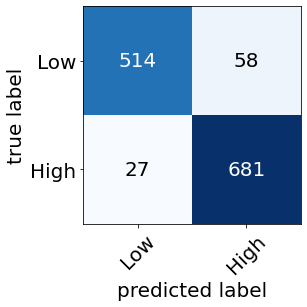

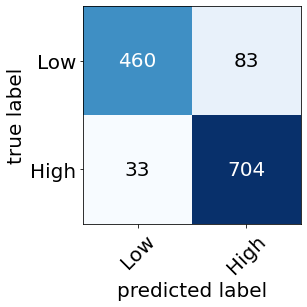

In [29]:
#===============================
# EDA results
#===============================

df = pd.read_csv(fname_eda)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('EDA Valence accuracy:')
print(val_acc_score)

print(' ')
print('EDA Valence F1 Score')
print(val_f1_scr)

print(' ')

print('EDA Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('EDA Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+classifier+'valence EDA.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('EDA Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('EDA Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('EDA Arousal Confiusion matric')
print(cm)

print(' ')

print('EDA Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal EDA.jpeg'

plt.savefig(fname2, bbox_inches='tight')